<a href="https://colab.research.google.com/github/AlexeyTri/PyTorchTutorials_2025/blob/main/12_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP COMPUTER VISION с использованием сверточных нейронных сетей

*Примечание: почему бы просто не использовать глубокую нейронную сеть с полносвязными слоями для задач распознавания изображений? К сожалению, хотя этот подход отлично работает для небольших изображений (например, Fashion MNIST), для изображений большего размера он неэффективен из-за огромного количества требуемых параметров. Например, изображение размером 100 × 100 пикселей имеет 10 000 пикселей, и если в первом слое всего 1000 нейронов (что уже серьёзно ограничивает объём информации, передаваемой следующему слою), это означает в общей сложности 10 миллионов связей. И это только первый слой. Сверточные нейронные сети решают эту задачу, используя частично связанные слои и распределение веса.*

In [ ]:
import numpy as np
import torch
from sklearn.datasets import load_sample_images
import torchvision
import torchvision.transforms.v2 as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
!pip install torchmetrics
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.9 MB/s eta 0:00:00


In [ ]:
def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [ ]:
torch.manual_seed(42)

# Сверточные слои

**Самый важный строительный блок CNN — это сверточный слой : 6 нейронов в первом сверточном слое не связаны с каждым отдельным пикселем входного изображения**

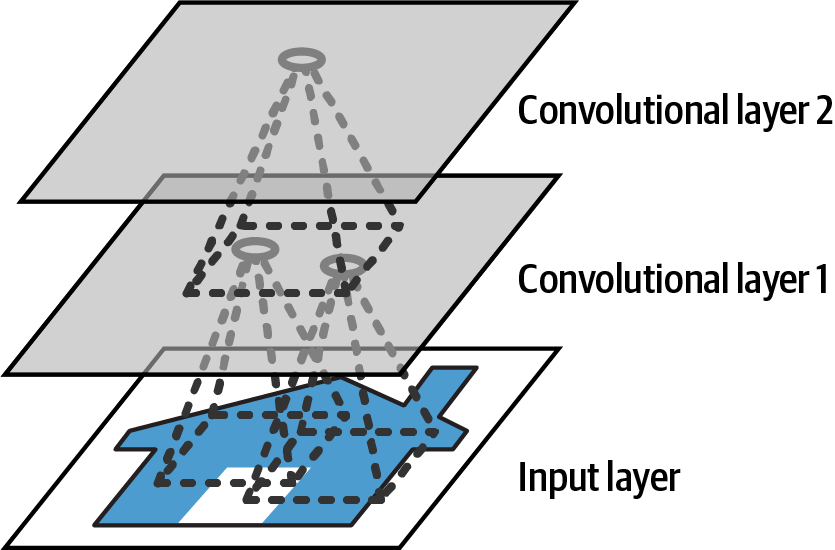

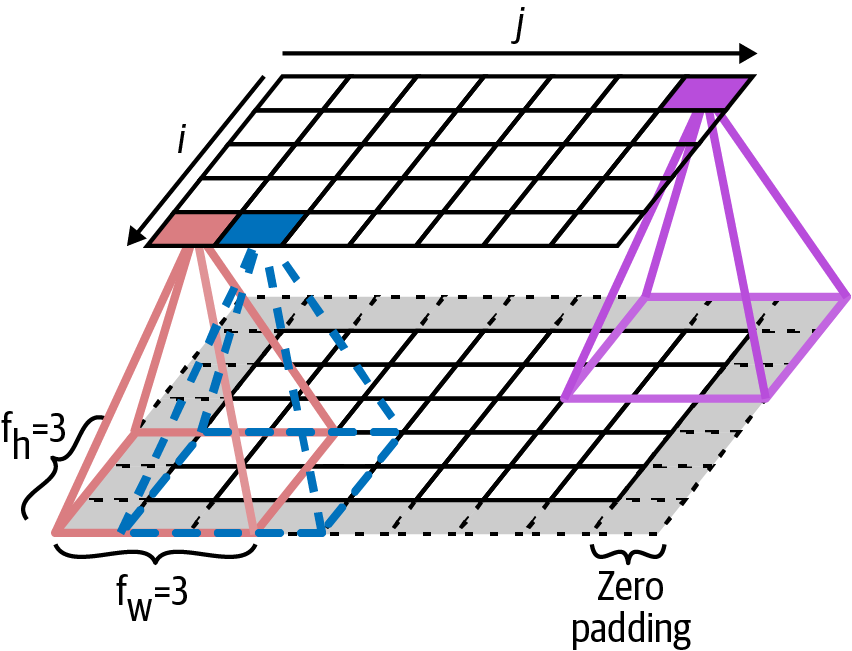

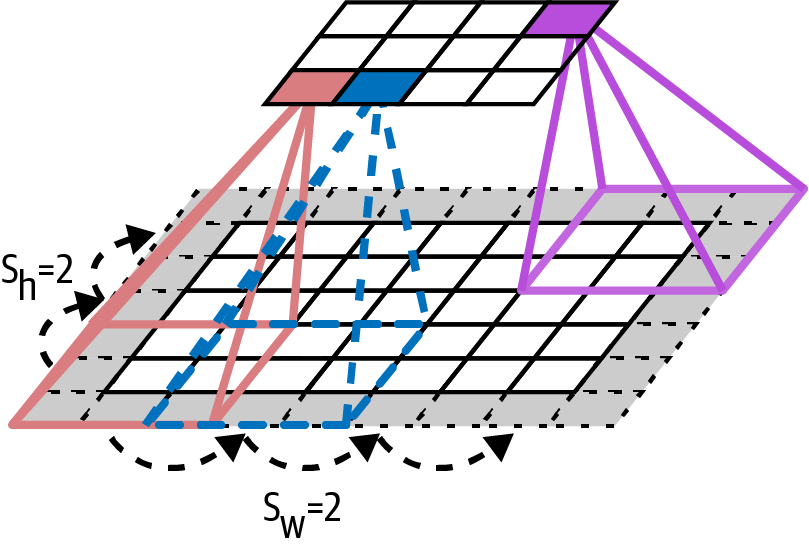

*Фильтры*

Веса нейрона можно представить в виде небольшого изображения размером с рецептивное поле. Например, на рисунке показаны два возможных набора весов, называемых фильтрами (или ядрами свертки , или просто ядрами ). Первый из них представлен в виде черного квадрата с вертикальной белой линией посередине (это матрица 7 × 7, заполненная нулями, за исключением центрального столбца, который заполнен единицами); нейроны, использующие эти веса, будут игнорировать все в своем рецептивном поле, за исключением центральной вертикальной линии (поскольку все входы будут умножены на 0, за исключением тех, что находятся на центральной вертикальной линии). Второй фильтр — черный квадрат с горизонтальной белой линией посередине. Нейроны, использующие эти веса, будут игнорировать все в своем рецептивном поле, за исключением центральной горизонтальной линии.

hmls_1205.png

*Объединение нескольких карт объектов*

До сих пор для простоты мы представляли каждый сверточный слой как 2D-слой, но в действительности сверточный слой имеет несколько фильтров (вы решаете, сколько) и выводит одну карту признаков на каждый фильтр, поэтому выходные данные точнее представлены в 3D. На каждой карте признаков приходится один нейрон на пиксель, и все нейроны в пределах данной карты признаков имеют одни и те же параметры (т. е. одно и то же ядро ​​и смещение). Нейроны в разных картах признаков используют разные параметры. Рецептивное поле нейрона такое же, как описано ранее, но оно распространяется на все карты признаков предыдущего слоя. Короче говоря, сверточный слой одновременно применяет к своим входам несколько обучаемых фильтров, что делает его способным обнаруживать несколько признаков в любом месте своих входов.

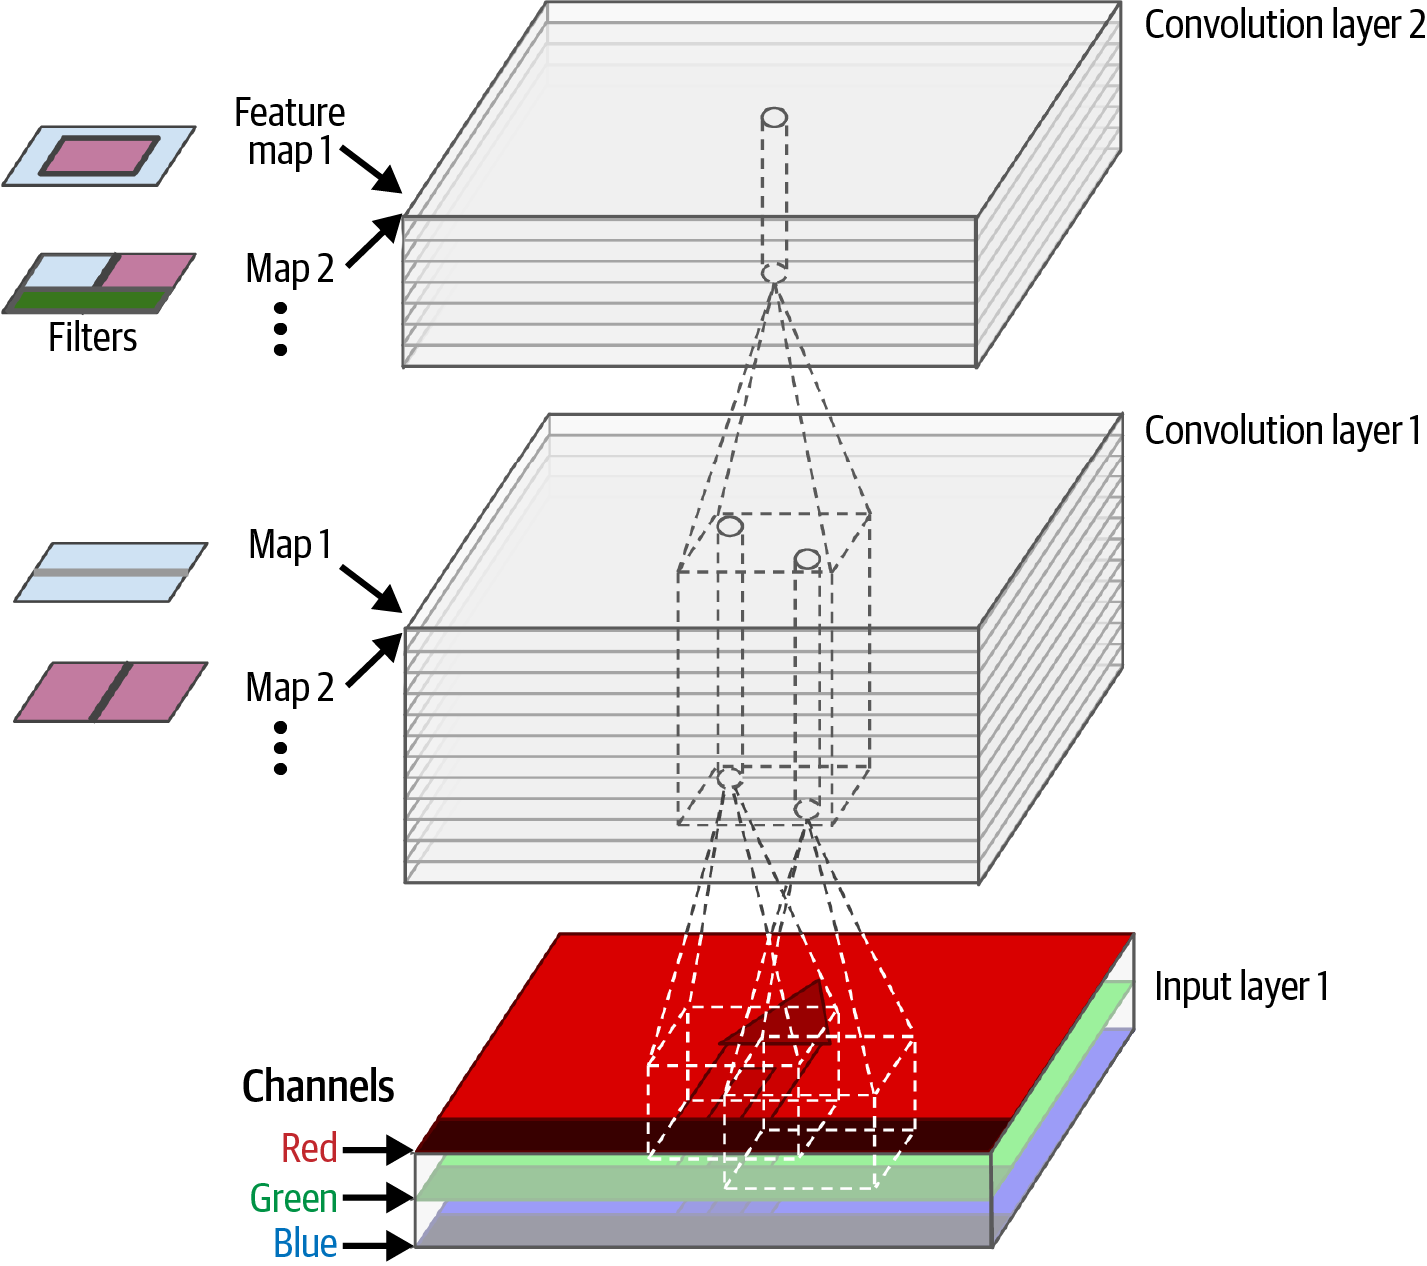

*Implementing Convolutional Layers with PyTorch*

In [ ]:
sample_image = np.stack(load_sample_images()["images"])
sample_image = torch.tensor(sample_image, dtype=torch.float32) / 255

In [ ]:
sample_image.shape

torch.Size([2, 427, 640, 3])

In [ ]:
sample_image_permuted = sample_image.permute(0,3,1,2)
sample_image_permuted.shape

torch.Size([2, 3, 427, 640])

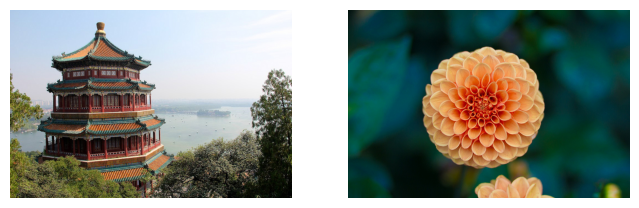

In [ ]:
def plot_image(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

plt.figure(figsize=(8,4))
for idx, image in enumerate(sample_image_permuted):
    plt.subplot(1, 2, idx+1)
    plot_image(image)

In [ ]:
cropped_images = T.CenterCrop((70, 120))(sample_image_permuted)
cropped_images.shape

torch.Size([2, 3, 70, 120])

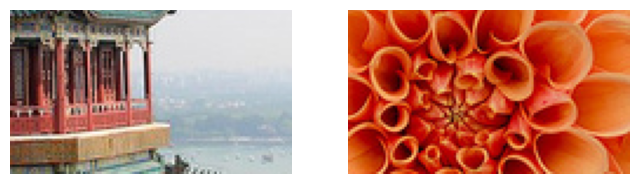

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_image(cropped_images[0])
plt.subplot(1, 2, 2)
plot_image(cropped_images[1])

In [ ]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
fmaps = conv_layer(cropped_images)

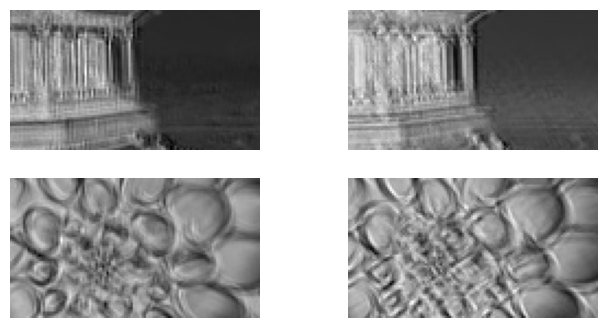

In [ ]:
plt.figure(figsize=(8, 4))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, fmap_idx].detach(), cmap="gray")
        plt.axis("off")

plt.show()

Теперь давайте создадим двумерный свёрточный слой и передадим ему эти обрезанные изображения, чтобы посмотреть, что получится. Для этого PyTorch предоставляет соответствующий nn.Conv2d слой. В основе этого слоя лежит torch.nn.functional.conv2d() функция . Давайте создадим свёрточный слой с 32 фильтрами, каждый размером 7 × 7 (используя kernel_size=7, что эквивалентно использованию kernel_size=(7 , 7)), и применим этот слой к нашей небольшой группе из двух изображений:

In [ ]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, padding=0)
fmaps = conv_layer(cropped_images)

In [ ]:
fmaps.shape

torch.Size([2, 32, 64, 114])

stride=1, kernel_size=7

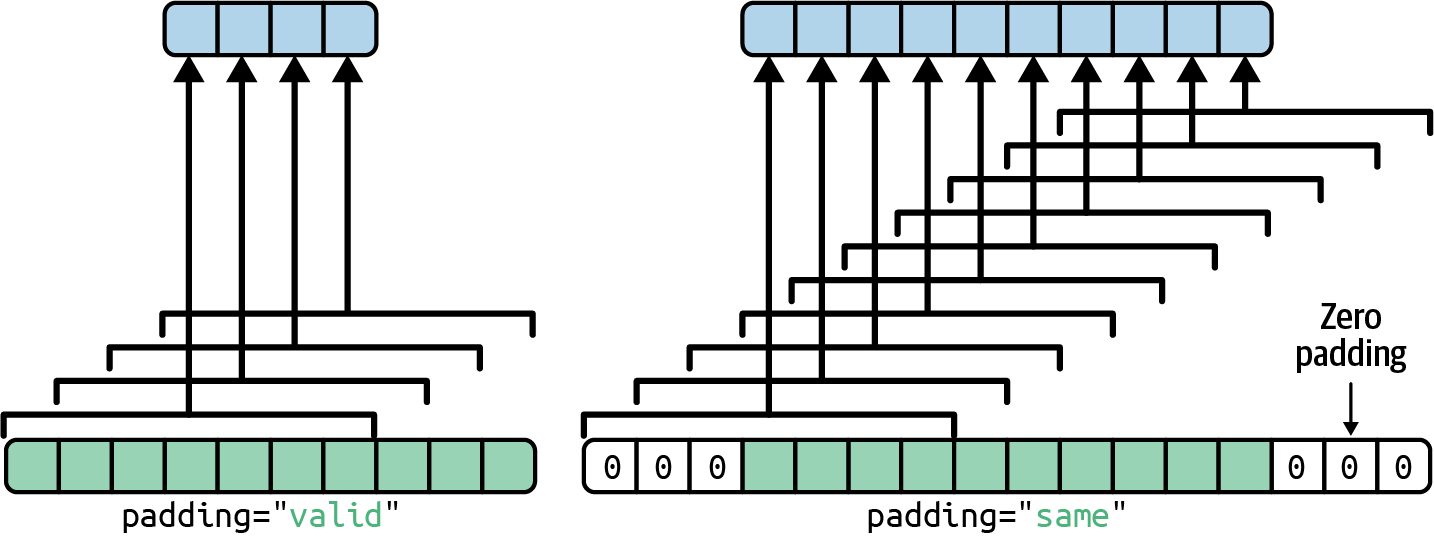

stride=2, kernel_size=7

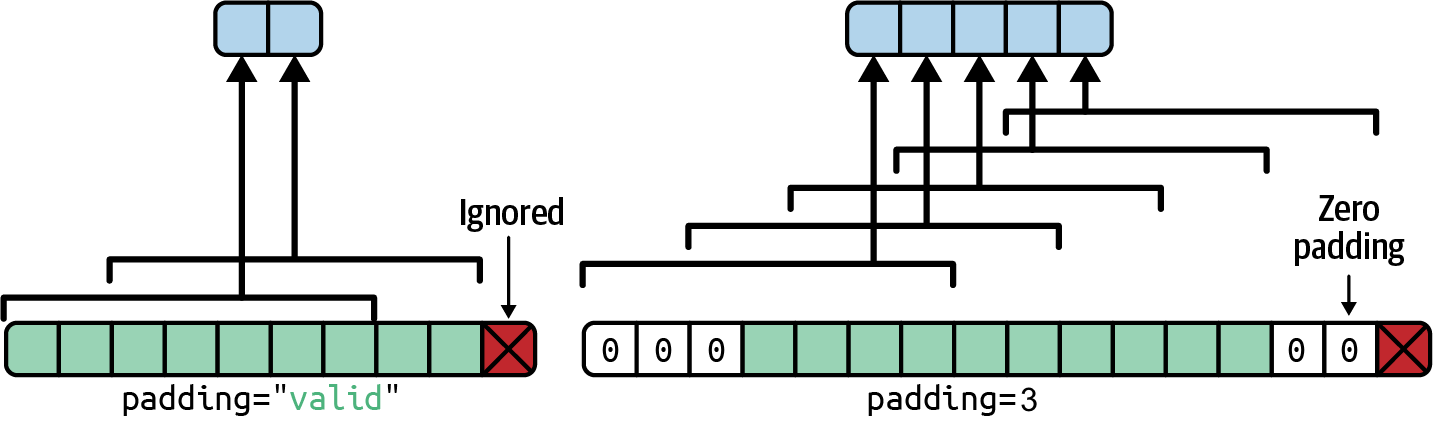

In [ ]:
conv_layer.weight.shape, conv_layer.bias.shape

(torch.Size([32, 3, 7, 7]), torch.Size([32]))

*Pooling Layers*

max_pooling: kernel_size=2, stride=2, no padding



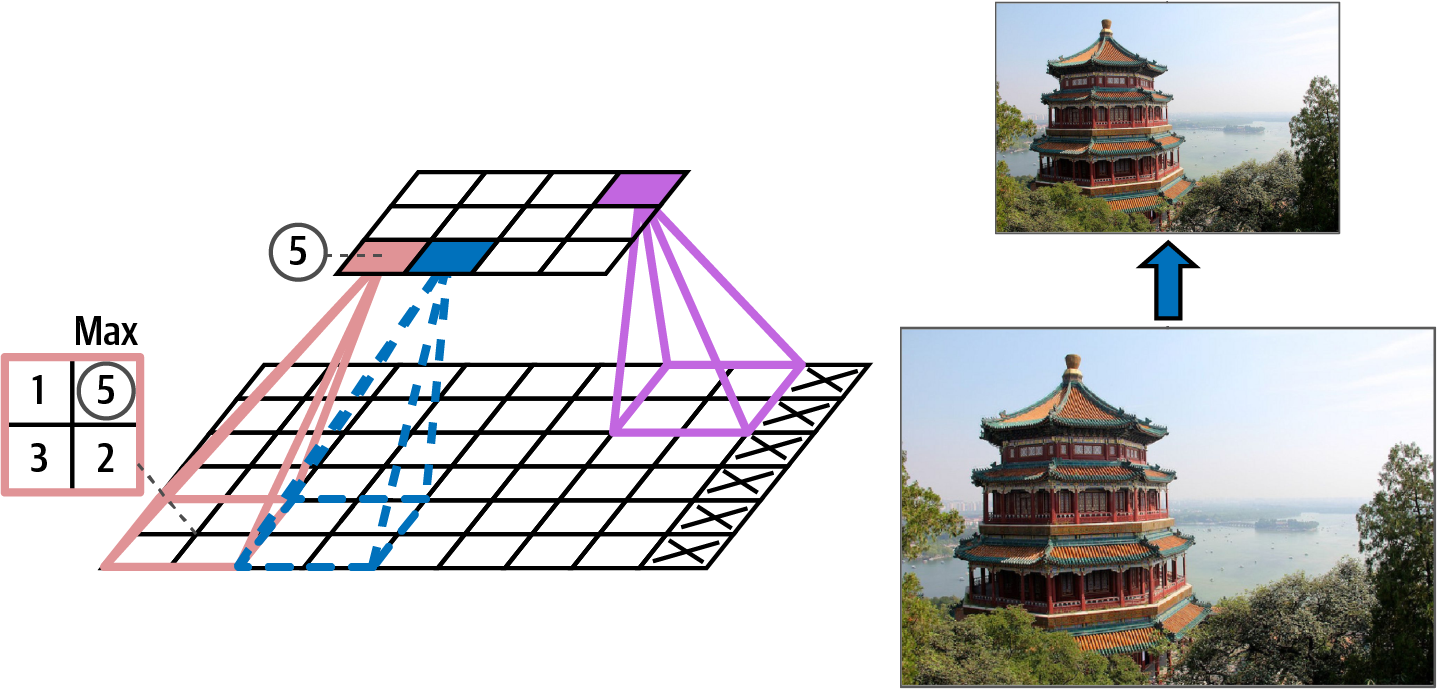

In [ ]:
class DepthMaxPool2(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        Z = inputs.view(batch, channels, height * width)  # merge spatial dims
        Z = Z.permute(0, 2, 1)  # switch spatial and channels dims
        Z = F.max_pool1d(Z, kernel_size=self.kernel_size, stride=self.stride,
                         padding=self.padding)  # compute max pool
        Z = Z.permute(0, 2, 1)# switch back spatial and channels dims
        return Z.view(batch, -1, height, width)  # unmerge spatial dims

In [ ]:
max_pool = nn.MaxPool2d(kernel_size=2)
depth_pool = DepthMaxPool2(kernel_size=4, stride=None)

In [ ]:
global_average_pool = nn.AvgPool2d(kernel_size=7)
avr_pool = global_average_pool(cropped_images)
max_pool = max_pool(cropped_images)
depth_pool_new = depth_pool(fmaps)

In [ ]:
fmaps.shape, depth_pool_new[0].permute(1,2,0).shape, max_pool.shape

(torch.Size([2, 32, 64, 114]),
 torch.Size([64, 114, 8]),
 torch.Size([2, 3, 35, 60]))

In [ ]:
global_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
output = global_avg_pool(cropped_images)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

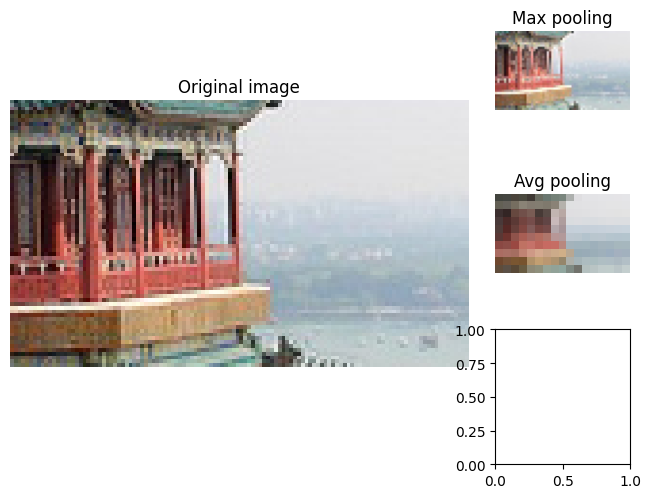

In [ ]:
fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot2grid((3, 4), (0, 0), rowspan=3, colspan=3)
ax1.imshow(cropped_images[0].permute(1, 2, 0))
ax1.axis('off')
ax1.set_title("Original image")

ax2 = plt.subplot2grid((3, 4), (0, 3))
ax2.imshow(max_pool[0].permute(1, 2, 0))
ax2.axis('off')
ax2.set_title("Max pooling")

ax3 = plt.subplot2grid((3, 4), (1, 3))
ax3.imshow(avr_pool[0].permute(1, 2, 0))
ax3.axis('off')
ax3.set_title("Avg pooling")

ax4 = plt.subplot2grid((3, 4), (2, 3))
ax4.imshow(depth_pool_new[0].permute(1, 2, 0))
ax4.axis('off')
ax4.set_title("Depth pooling")

plt.tight_layout()
plt.show()

In [ ]:
output = cropped_images.mean(dim=(2,3), keepdim=True)

# Архитектуры CNN

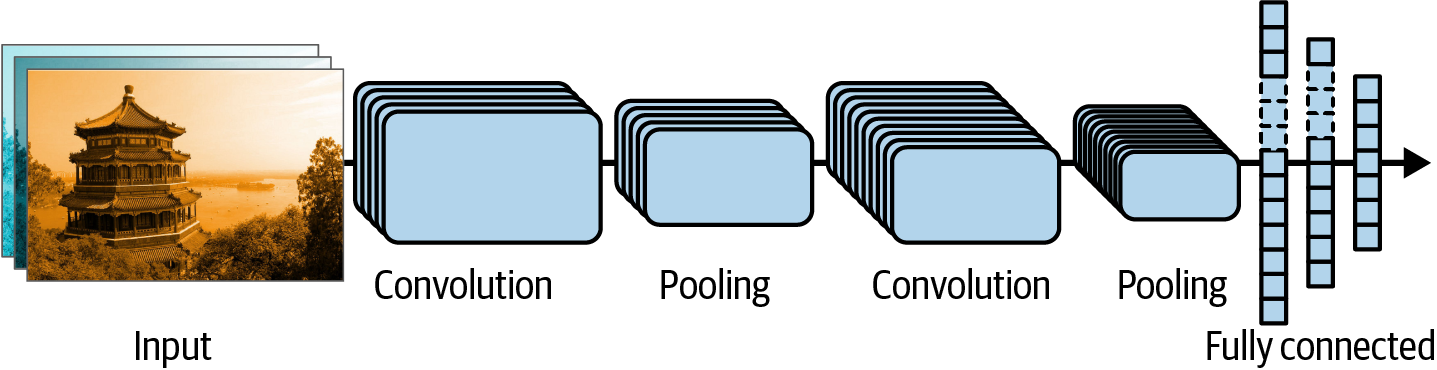

In [ ]:
from functools import partial

DefaultConv2d = partial(nn.Conv2d, kernel_size=3, padding="same")
model = nn.Sequential(
    DefaultConv2d(in_channels=1, out_channels=64, kernel_size=7, stride=1), nn.ReLU(), # 28*28*64
    nn.MaxPool2d(kernel_size=2), # 14*14 * 64
    DefaultConv2d(in_channels=64, out_channels=128), nn.ReLU(),
    DefaultConv2d(in_channels=128, out_channels=128), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), # 7*7 * 128
    DefaultConv2d(in_channels=128, out_channels=256), nn.ReLU(),
    DefaultConv2d(in_channels=256, out_channels=256), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), # 3*3 * 256
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=128), nn.ReLU(), # 3*3*256 = 2304
    nn.Dropout(0.5),
    nn.Linear(in_features=128, out_features=64), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=64, out_features=10)
    ).to(device=device)


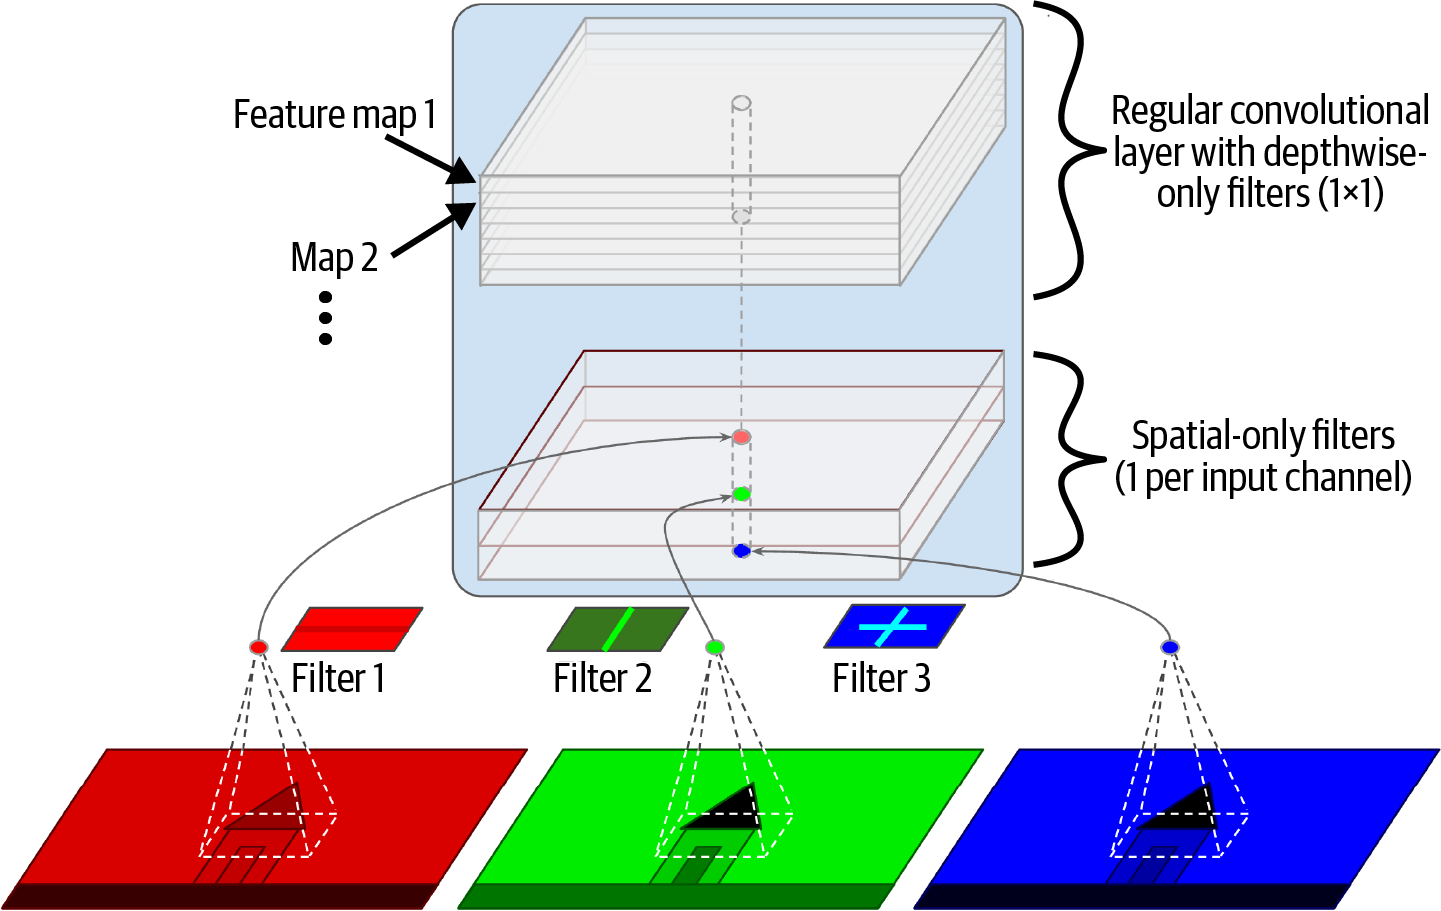

In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        super().__init__()
        self.depthwise_conv = nn.Conv2d(
            in_channels, in_channels, kernel_size, stride=stride,
            padding=padding, groups=in_channels)
        self.pointwise_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, inputs):
        return self.pointwise_conv(self.depthwise_conv(inputs))

# ResNet-34 CNN

class ResNet

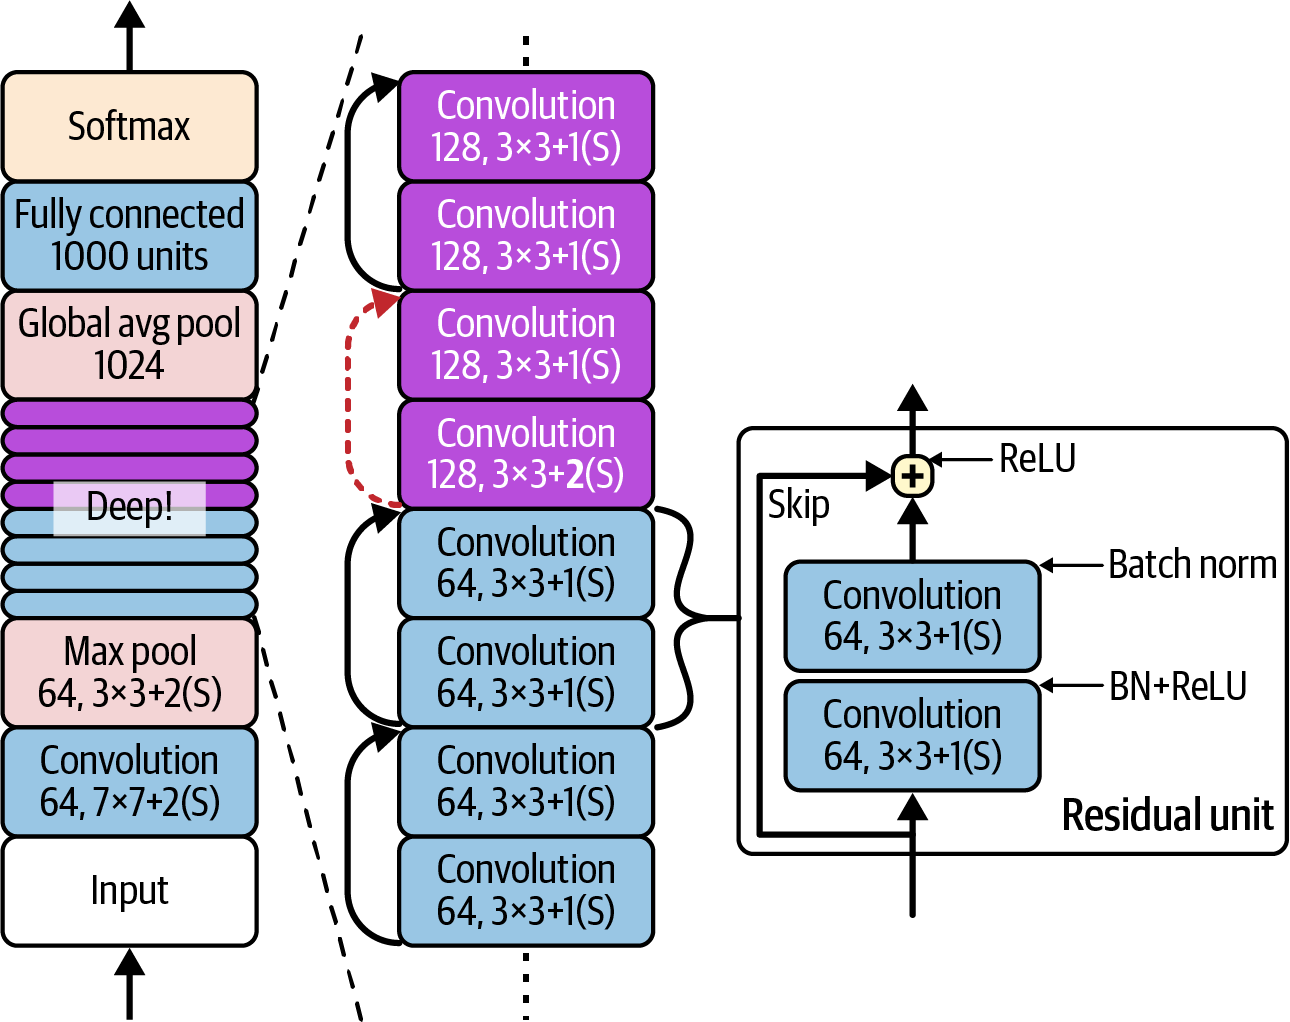

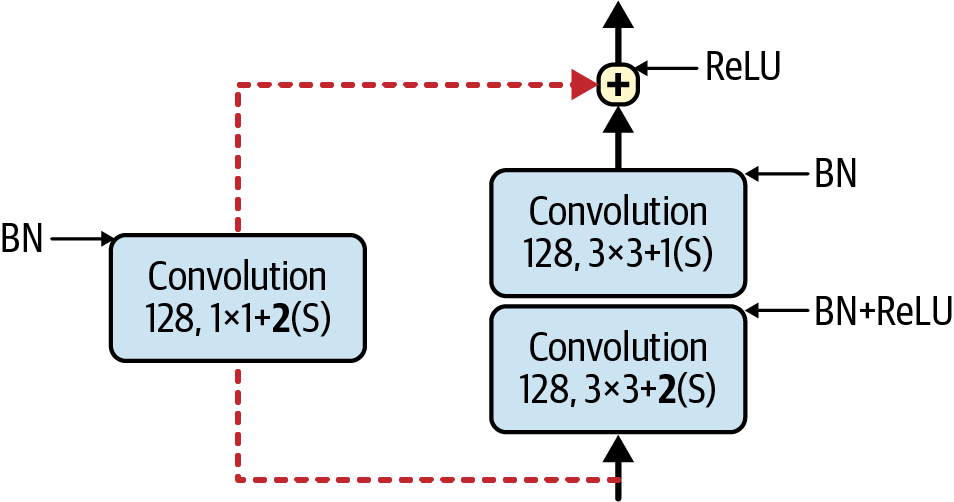

In [ ]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        DefaultConv2d = partial(nn.Conv2d, kernel_size=3, stride=1, padding=1, bias=False)
        self.main_layer = nn.Sequential(
            DefaultConv2d(in_channels=in_channels, out_channels=out_channels, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            DefaultConv2d(in_channels=out_channels, out_channels=out_channels),
            nn.BatchNorm2d(out_channels)
        )
        if stride > 1:
            self.skip_connection = nn.Sequential(
                DefaultConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip_connection = nn.Identity()
    def forward(self, inputs):
        return F.relu(self.main_layer(inputs) + self.skip_connection(inputs))

In [ ]:
class ResNet34(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        prev_filters = 64
        for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
            stride = 1 if filters == prev_filters else 2
            layers.append(
                ResidualUnit(prev_filters, filters, stride=stride))
            prev_filters = filters
        layers += [
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.LazyLinear(10)
        ]

        self.resnet = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.resnet(inputs)

# Использование предварительно обученных моделей TorchVision

In [ ]:
weights = torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1
model = torchvision.models.convnext_base(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|██████████| 338M/338M [00:02<00:00, 124MB/s]


Чтобы получить полный список доступных моделей, запустите torchvision.models.list_models(). Чтобы найти список предварительно обученных весов, доступных для заданной модели, например convnext_base, запустите list(torchvision.models.get_model_weights("convnext_base")). Также посетите https://pytorch.org/vision/main/models .

In [ ]:
torch.hub.get_dir()

'/root/.cache/torch/hub'

In [ ]:
transforms = weights.transforms()
preprocessed_images = transforms(sample_image_permuted)

In [ ]:
model.eval()
with torch.no_grad():
    y_logits = model(preprocessed_images.to(device))

In [ ]:
y_pred = torch.argmax(y_logits, dim=1)
y_pred

tensor([698, 985], device='cuda:0')

In [ ]:
class_names = weights.meta['categories']
[class_names[class_id] for class_id in y_pred]

['palace', 'daisy']

In [ ]:
y_top3_logits, y_top3_class_ids = y_logits.topk(k=3, dim=1)
[[class_names[class_id] for class_id in top3] for top3 in y_top3_class_ids]

[['palace', 'monastery', 'lakeside'], ['daisy', 'pot', 'ant']]

In [ ]:
y_top3_logits.softmax(dim=1)

tensor([[0.8618, 0.1185, 0.0197],
        [0.8106, 0.0964, 0.0930]], device='cuda:0')

# Предварительно обученные модели для трансферного обучения

In [ ]:
DefaultFlowers102 = partial(torchvision.datasets.Flowers102, root="datasets",
                            transform=weights.transforms(), download=True)
train_set = DefaultFlowers102(split="train")
valid_set = DefaultFlowers102(split="val")
test_set = DefaultFlowers102(split="test")

100%|██████████| 345M/345M [00:13<00:00, 25.7MB/s]
100%|██████████| 502/502 [00:00<00:00, 2.41MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 54.6MB/s]


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [ ]:
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
len(class_names)

102

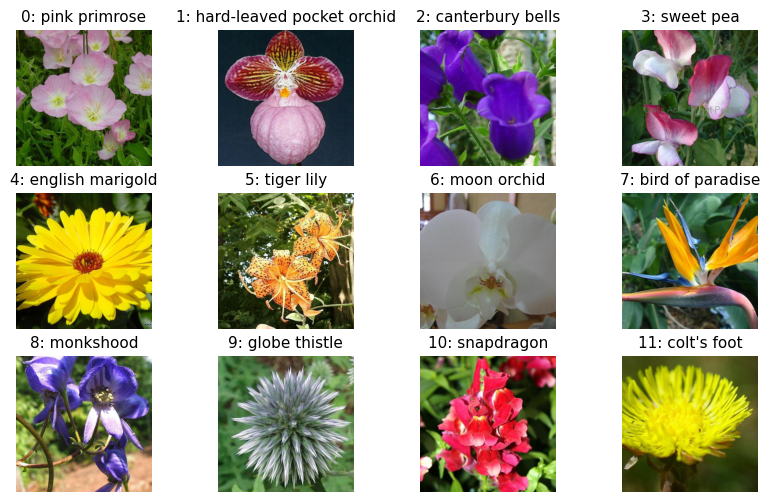

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(500),
])
flowers_to_display = DefaultFlowers102(split="train", transform=transform)
sample_flowers = sorted({y: img for img, y in flowers_to_display}.items())[:12]

plt.figure(figsize=(10, 6))
for class_id, image in sample_flowers:
    if class_id == 12: break
    plt.subplot(3, 4, class_id + 1)
    plot_image(image)
    plt.title(f"{class_id}: {class_names[class_id]}", fontsize=11)

plt.show()

In [ ]:
 [name for name, child in model.named_children()]

['features', 'avgpool', 'classifier']

In [ ]:
model.classifier

Sequential(
  (0): LayerNorm2d((1024,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=1000, bias=True)
)

In [ ]:
n_classes = 102
model.classifier[2] = nn.Linear(1024, n_classes).to(device)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
n_epochs = 5
optimizer = torch.optim.AdamW(model.parameters())
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass",
                                 num_classes=102).to(device)
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)

Epoch 1/5, train loss: 4.2843, train metric: 0.1480, valid metric: 0.5696
Epoch 2/5, train loss: 3.0015, train metric: 0.7196, valid metric: 0.7696
Epoch 3/5, train loss: 2.0661, train metric: 0.8392, valid metric: 0.8461
Epoch 4/5, train loss: 1.3710, train metric: 0.9029, valid metric: 0.8618
Epoch 5/5, train loss: 0.9468, train metric: 0.9422, valid metric: 0.8706


In [ ]:
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)

Epoch 1/5, train loss: 0.6861, train metric: 0.9627, valid metric: 0.8765
Epoch 2/5, train loss: 0.5003, train metric: 0.9784, valid metric: 0.8863
Epoch 3/5, train loss: 0.3925, train metric: 0.9804, valid metric: 0.8814
Epoch 4/5, train loss: 0.3139, train metric: 0.9873, valid metric: 0.8941
Epoch 5/5, train loss: 0.2516, train metric: 0.9873, valid metric: 0.8912


In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)

Epoch 1/5, train loss: 0.7352, train metric: 0.8010, valid metric: 0.7775
Epoch 2/5, train loss: 0.3090, train metric: 0.9147, valid metric: 0.8676
Epoch 3/5, train loss: 0.0976, train metric: 0.9716, valid metric: 0.8755
Epoch 4/5, train loss: 0.0982, train metric: 0.9735, valid metric: 0.8186
Epoch 5/5, train loss: 0.0997, train metric: 0.9775, valid metric: 0.8667


In [ ]:
import torchvision.transforms.v2 as T

transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=30),
    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Классификация и локализация

In [ ]:
class FlowerLocator(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.localization_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_model.classifier[2].in_features, 4)
        )

    def forward(self, X):
        features = self.base_model.features(X)
        pool = self.base_model.avgpool(features)
        logits = self.base_model.classifier(pool)
        bbox = self.localization_head(pool)
        return logits, bbox

torch.manual_seed(42)
locator_model = FlowerLocator(model).to(device)

In [ ]:
preproc_images = torch.randn(2, 3, 224, 224)  # a batch of preprocessed images
y_pred_logits, y_pred_bbox = locator_model(preprocessed_images.to(device))

In [ ]:
import torchvision.tv_tensors

bbox = torchvision.tv_tensors.BoundingBoxes(
    [[377, 199, 248, 262]],  # center x=377, center y=199, width=248, height=262
    format="CXCYWH",  # other possible formats: "XYXY" and "XYWH"
    canvas_size=(500, 754)  # raw image size before preprocessing
)

In [ ]:
transform(bbox)

BoundingBoxes([[ 90,  91, 120, 154]], format=BoundingBoxFormat.CXCYWH, canvas_size=(224, 224), clamping_mode=soft)

In [ ]:
torch.manual_seed(42)

# load the first training image without any preprocessing
first_image = torchvision.datasets.Flowers102(root="datasets", split="train")[0][0]

preproc_image, preproc_target = transform(
    (first_image, {"label": 0, "bbox": bbox})
)
preproc_bbox = preproc_target["bbox"]

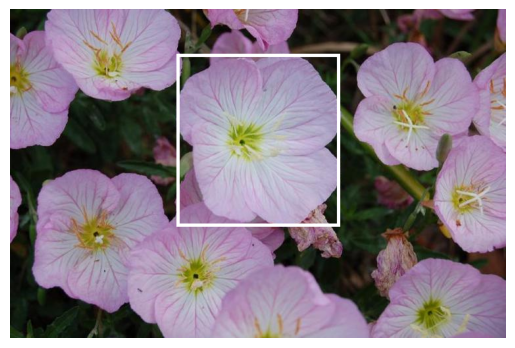

In [ ]:
def plot_image(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")
def get_image_with_bbox(image, bbox, width=5, color="white"):
    bbox_xyxy = torchvision.ops.box_convert(bbox, "cxcywh", "xyxy")
    return torchvision.utils.draw_bounding_boxes(
        image, bbox_xyxy, width=width, colors=color)

first_image_ts = T.ToImage()(first_image)
image_with_bbox = get_image_with_bbox(first_image_ts, bbox)
plot_image(image_with_bbox)
plt.show()

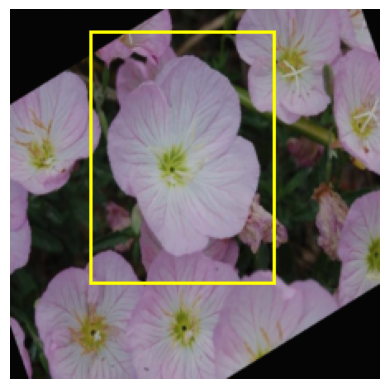

In [ ]:
def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    return (image * torch.tensor(std).view(-1, 1, 1)
            + torch.tensor(mean).view(-1, 1, 1))


image_with_bbox2 = get_image_with_bbox(
    denormalize(preproc_image), preproc_bbox, width=2, color="yellow")
plot_image(image_with_bbox2)

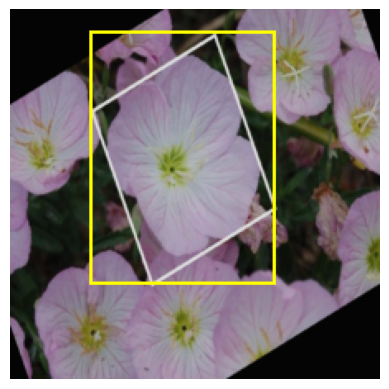

In [ ]:
torch.manual_seed(42)

preproc_image2, preproc_target2 = transform(
    (image_with_bbox, {"label": 0, "bbox": bbox})
)
image_and_bbox3 = get_image_with_bbox(
    denormalize(preproc_image2), preproc_target2["bbox"], width=2, color="yellow")
plot_image(image_and_bbox3)

In [ ]:
bboxes = [
    torchvision.tv_tensors.BoundingBoxes(
        [[377, 199, 248, 262]],
        format="CXCYWH",
        canvas_size=(500, 754)
    ),
    torchvision.tv_tensors.BoundingBoxes(
        [[314, 248, 437, 445]],
        format="CXCYWH",
        canvas_size=(500, 624)  # note that image sizes vary
    )
]

In [ ]:
class FlowersWithBBox(torch.utils.data.Dataset):
    def __init__(self, root, bboxes, transform=None, split="train"):
        self.image_dataset = torchvision.datasets.Flowers102(root=root,
                                                             split=split)
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.bboxes)

    def __getitem__(self, index):
        raw_image, label = self.image_dataset[index]
        image = torchvision.tv_tensors.Image(raw_image)
        bbox = self.bboxes[index]
        preproc_image, preproc_bbox = self.transform(image, bbox)
        return preproc_image, {"label": label, "bbox": preproc_bbox}

train_set_with_bboxes = FlowersWithBBox("datasets", bboxes, transform=transform)

In [ ]:
train_loader_with_bboxes = DataLoader(train_set_with_bboxes, batch_size=2)
for images, label_and_bbox in train_loader_with_bboxes:
    label = label_and_bbox["label"]
    bbox = label_and_bbox["bbox"]
    # we could train the model here

# Object Detection

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov9m.pt')  # n = nano variant, larger variants are s, m, and x
images = ["https://homl.info/soccer.jpg", "https://homl.info/traffic.jpg"]
results = model(images)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 640x640 5 persons, 2 sports balls, 51.1ms
1: 640x640 3 persons, 7 cars, 1 motorcycle, 11 trucks, 51.1ms
Speed: 9.7ms preprocess, 51.1ms inference, 11.8ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
 results[0].summary()[0]

{'name': 'sports ball',
 'class': 32,
 'confidence': 0.96214,
 'box': {'x1': 245.35733, 'y1': 286.03003, 'x2': 300.62509, 'y2': 343.57184}}

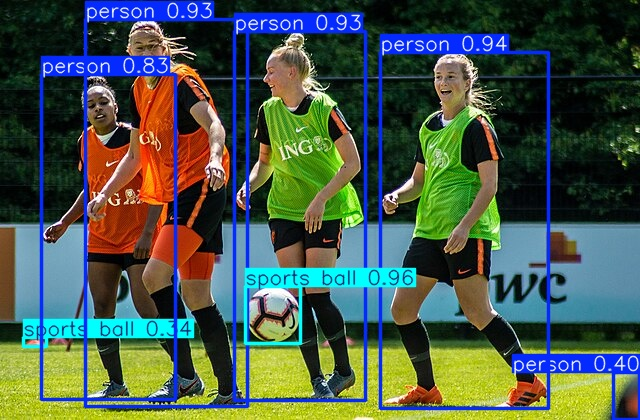

In [ ]:
import PIL

results[0].save("my_annotated_soccer.jpg")
PIL.Image.open("my_annotated_soccer.jpg")

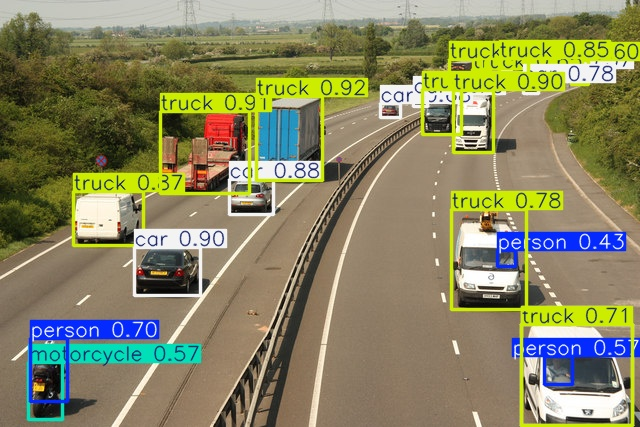

In [ ]:
results[1].save("my_annotated_traffic.jpg")
PIL.Image.open("my_annotated_traffic.jpg")

# Object Tracking

In [ ]:
my_video = "https://homl.info/cars.mp4"
results = model.track(source=my_video, stream=True, save=True)
for frame_results in results:
    summary = frame_results.summary()  # similar summary as earlier + track id
    track_ids = [obj["track_id"] for obj in summary]
    print("Track ids:", track_ids)

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 0.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


video 1/1 (frame 1/243) /content/cars.mp4: 384x640 1 person, 8 cars, 1 bus, 1 truck, 60.0ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
video 1/1 (frame 2/243) /content/cars.mp4: 384x640 1 person, 8 cars, 1 bus, 1 truck, 26.8ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
video 1/1 (frame 3/243) /content/cars.mp4: 384x640 8 cars, 1 bus, 1 truck, 26.8ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
video 1/1 (frame 4/243) /content/cars.mp4: 384x640 7 cars, 1 bus, 1 truck, 32.1ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 10]
video 1/1 (frame 5/243) /content/cars.mp4: 384x640 7 cars, 1 bus, 1 truck, 26.9ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 10]
video 1/1 (frame 6/243) /content/cars.mp4: 384x640 7 cars, 1 bus, 1 truck, 26.9ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 10]
video 1/1 (fr

# Semantic Segmentation

In [ ]:
from pathlib import Path
import urllib.request

def download_file(url, path):
    path = Path(path)
    if not path.is_file():
        path.parent.mkdir(parents=True, exist_ok=True)
        urllib.request.urlretrieve(url, path)

download_file("https://homl.info/soccer.jpg", "datasets/images/soccer.jpg")

In [ ]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval()

img = PIL.Image.open("datasets/images/soccer.jpg")
transform = weights.transforms()
batch = transform(img).unsqueeze(0)  # unsqueeze() adds a dimension of size 1

with torch.no_grad():
    masks = model(batch)["out"].softmax(dim=1)

class_names = weights.meta["categories"]
name_to_id = {name: class_id for class_id, name in enumerate(class_names)}
mask = masks[0, name_to_id["person"]]

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


100%|██████████| 135M/135M [00:00<00:00, 186MB/s]


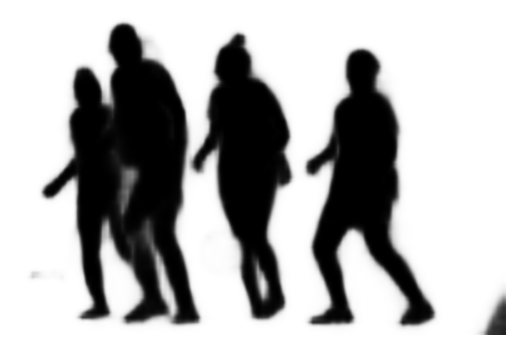

In [ ]:
plt.imshow(mask, cmap="binary")
plt.axis('off')
plt.show()

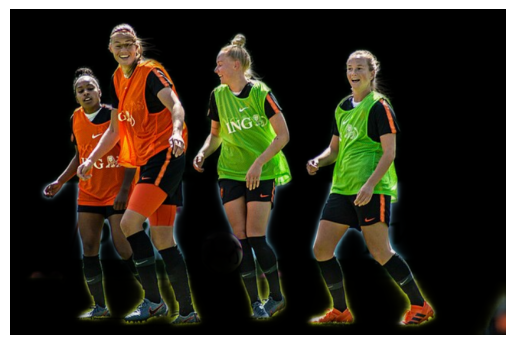

In [ ]:
masked_image = mask.unsqueeze(0) * denormalize(batch.squeeze(0))
plot_image(masked_image)

# Extra Material – How mAP Relates to Precision/Recall

In [ ]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

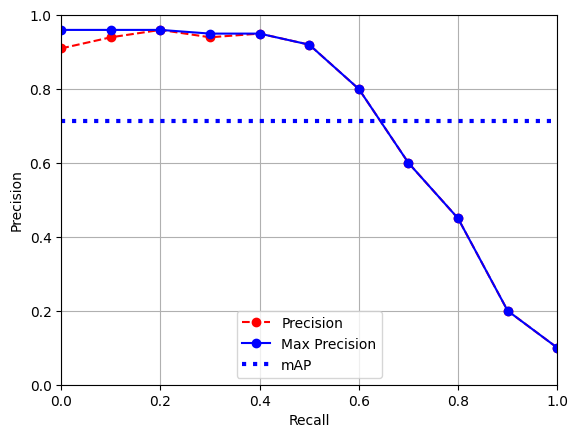

In [ ]:
import numpy as np

recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "b:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()